## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=r"C:\Users\UNI\Desktop\DL in CV\project\hotdog_nothotdog"):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), #squishing image to a square
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0) #3 doesnt work
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

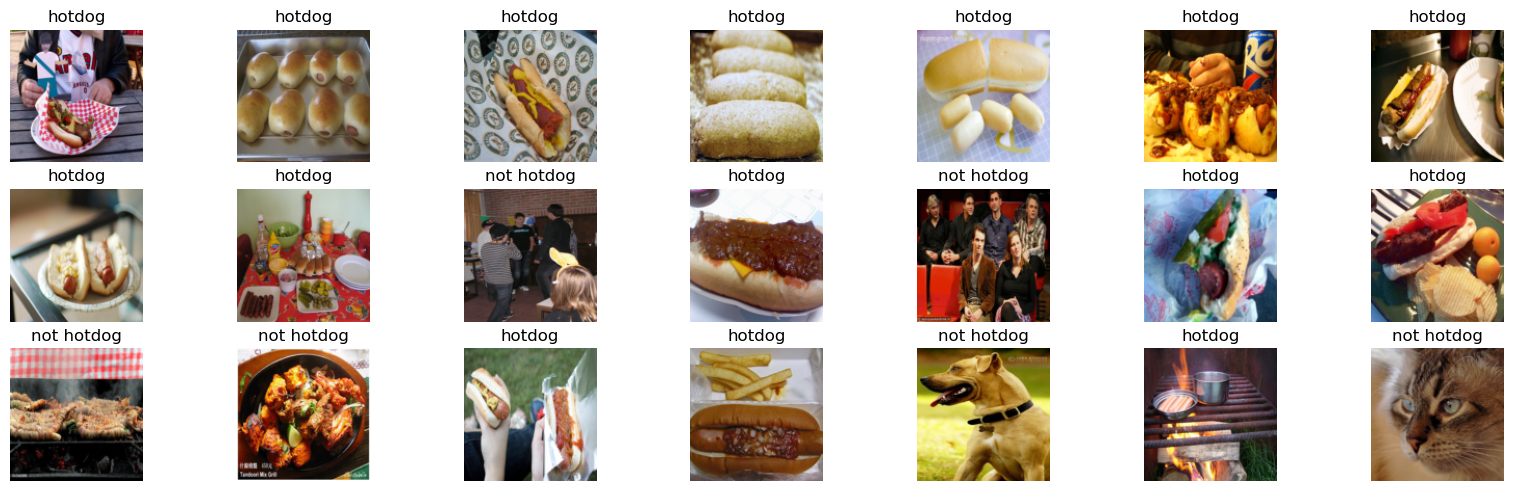

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [ ]:
class HotdogCNN(nn.Module):
    def __init__(self, dropout=0.2):
        super(HotdogCNN, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),  # 3 input channels; padding 1 to get full image
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128×128 to 64×64

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),   # 64×64 to 32×32

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 64×64 to 32×32
        )

        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(32 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 2)   # 2 classes: hotdog / not hotdog
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = self.classifier(x)
        return x


In [7]:
def get_optimizer(model, name="adam", lr=1e-3, weight_decay=0.0):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    if name == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # "adam" default


In [ ]:

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    correct, total, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += nn.CrossEntropyLoss()(logits, y).item() * x.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        total    += x.size(0)
    return loss_sum/max(1,total), correct/max(1,total)


# Run multiple tests

In [ ]:
def run_config(cfg, epochs=10):
    
    model = HotdogCNN(dropout=cfg["dropout"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model,
                              name=cfg["opt"],
                              lr=cfg["lr"],
                              weight_decay=cfg["wd"])
    best_state, best_val = None, -1.0

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        va_loss, va_acc = eval_epoch(model, test_loader, criterion)  
        print(f"[{cfg}]  Ep {ep:02d} | train {tr_acc*100:.1f}% ({tr_loss:.4f}) | val {va_acc*100:.1f}% ({va_loss:.4f})")
        if va_acc > best_val:
            best_val = va_acc
            best_state = {k:v.detach().cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val, model

In [10]:
configs = [
    # adam with dropout
    {"dropout":0.0, "opt":"adam",  "lr":1e-3, "wd":0.0},
    {"dropout":0.1, "opt":"adam",  "lr":1e-3, "wd":0.0},
    {"dropout":0.2, "opt":"adam",  "lr":1e-3, "wd":0.0},
    {"dropout":0.2, "opt":"adam",  "lr":1e-2, "wd":0.0},

    # adamw
    {"dropout":0.1, "opt":"adamw", "lr":1e-3, "wd":1e-4},
    {"dropout":0.1, "opt":"adamw", "lr":1e-3, "wd":0.0},
    {"dropout":0.1, "opt":"adamw", "lr":1e-4, "wd":1e-4},

    # sgd
    {"dropout":0.1, "opt":"sgd",   "lr":1e-3, "wd":1e-4},
    {"dropout":0.1, "opt":"sgd",   "lr":1e-2, "wd":1e-4},
]



In [11]:
results = []
best_model = None
best_acc = -1.0

for cfg in configs:
    val_acc, model = run_config(cfg, epochs=10)
    results.append((cfg, float(val_acc)))
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model

# sort & show
results = sorted(results, key=lambda x: x[1], reverse=True)
print("\n=== Summary (val acc) ===")
for cfg, acc in results:
    print(f"{acc*100:5.1f}%  {cfg}")

[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 01 | train 65.8% (1.0756) | val 49.7% (0.7536)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 02 | train 75.4% (0.5162) | val 73.6% (0.5319)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 03 | train 79.9% (0.4380) | val 76.3% (0.5111)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 04 | train 81.2% (0.4144) | val 76.1% (0.5655)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 05 | train 84.0% (0.3604) | val 73.6% (0.6735)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 06 | train 86.0% (0.3329) | val 71.9% (0.7789)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 07 | train 88.2% (0.2781) | val 73.4% (0.5569)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 08 | train 91.2% (0.2133) | val 76.2% (0.5908)
[{'dropout': 0.0, 'opt': 'adam', 'lr': 0.001, 'wd': 0.0}]  Ep 09 | train 89.5% (0.2457) | val 74.2% (0.8992)
[{'dropout': 0.0, '